# Интернет магазин. Проверка А/Б тестов.
Отдел маркетинга подготовил список гипотез для увеличения выручки.

Задача: 
- приоритизировать гипотезы
- запустить A/B-тест и проанализировать результаты. 

Данные для анализа: 

Файл `hypothesis.csv`

|столбец|описание:|
|--:|:--|
|Hypothesis |краткое описание гипотезы|
|Reach|охват пользователей по 10-балльной шкале|
|Impact|влияние на пользователей по 10-балльной шкале|
|Confidence|уверенность в гипотезе по 10-балльной шкале|
|Efforts|затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы|


Файл `datasets/orders.csv`

|столбец|описание:|
|--:|:--|
|transactionId |идентификатор заказа|
|visitorId|идентификатор пользователя, совершившего заказ|
|date|дата, когда был совершён заказ|
|revenue|выручка заказа|
|group|группа A/B-теста| в которую попал заказ|


Файл `visitors.csv`

|столбец|описание:|
|--:|:--|
|date|дата|
|group|группа A/B-теста|
|visitors|количество пользователей в указанную дату в указанной группе A/B-теста|



## 1. Загрузка данных, предобработка

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
import datetime as dt


In [2]:
try:
    df = pd.read_csv('hypothesis.csv')
except: 
    df = pd.read_csv('/datasets/hypothesis.csv')
    
try:
    orders = pd.read_csv('orders.csv')
except: 
    orders = pd.read_csv('/datasets/orders.csv')    
    
try:
    visitors = pd.read_csv('visitors.csv')
except: 
    visitors = pd.read_csv('/datasets/visitors.csv')

### 1.1 Размерность, просмотр начальных и конечных записей наборов, информация по типам

In [3]:
tabs={'hypothesis': df,'orders':orders, 'visitors': visitors}
for key in tabs:
    print('\033[1m' + f'Первые 5 строк таблицы {key}'+'\033[0m')
    display(tabs[key].head(5))
    print('\033[1m' + f'Последние 5 строк таблицы {key}'+'\033[0m')
    display(tabs[key].tail(5))
    print('\033[1m' + f'Информация по столбцам таблицы {key}'+'\033[0m')
    display(tabs[key].info())

Первые 5 строк таблицы hypothesis


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


Последние 5 строк таблицы hypothesis


,Hypothesis,Reach,Impact,Confidence,Efforts
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Информация по столбцам таблицы hypothesis
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 388.0+ bytes


None

Первые 5 строк таблицы orders


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Последние 5 строк таблицы orders


,transactionId,visitorId,date,revenue,group
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A
1196,3936777065,2108080724,2019-08-15,202740,B


Информация по столбцам таблицы orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 37.5+ KB


None

Первые 5 строк таблицы visitors


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Последние 5 строк таблицы visitors


,date,group,visitors
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490
61,2019-08-31,B,718


Информация по столбцам таблицы visitors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ KB


None

### Вывод по шагу 1.1: 
- пропусков в данных нет
- в таблице с гипотезами `hypothesis` столбцы следует переименовать, перевести в нижний регистр
- даты в 2х таблицах следует перевести в формат даты


In [4]:
df.columns=df.columns.str.lower() #замена регистра  

In [5]:
orders = orders.rename({'transactionId': 'order_id', 'visitorId': 'user_id'}, axis=1) 

In [6]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) #перевод даты в нужный формат

In [7]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) #перевод даты в нужный формат

### 1.2 Проверка данных на дубликаты.

In [8]:
df.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
visitors.duplicated().sum()

0

### 1.3 Дополнительные исследования данных по А/Б тестам

#### 1.3.1 Проверка количества групп

In [11]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [12]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

**В данных представлены 2 группы, обозначенные А и В**

#### 1.3.2 Временной интервал проводимого теста

In [13]:
dt_orders=[]
dt_orders.append(min(orders['date'].dt.date))
dt_orders.append(max(orders['date'].dt.date))
print('Временной интервал таблицы orders ', dt_orders)

Временной интервал таблицы orders  [datetime.date(2019, 8, 1), datetime.date(2019, 8, 31)]


In [14]:
dt_visitors=[]
dt_visitors.append(min(visitors['date'].dt.date))
dt_visitors.append(max(visitors['date'].dt.date))
print('Временной интервал таблицы visitors ', dt_orders)

Временной интервал таблицы visitors  [datetime.date(2019, 8, 1), datetime.date(2019, 8, 31)]


**даты проведеня эксперемента в 2-х таблицах совпадают, и временной интервал эксперемента составляет c 1 по 31 августа 2019 года** 

#### 1.3.3 Количество пользователей в каждой группе 

In [15]:
count_user_a = orders['user_id'][orders['group']=='A'].nunique()

In [16]:
count_user_b = orders['user_id'][orders['group']=='B'].nunique()

In [17]:
print(f'Количество пользователей в группе А = {count_user_a}, а в группе В = {count_user_b}')

Количество пользователей в группе А = 503, а в группе В = 586


**группы не равные по колличеству, это стоит отметить и задать вопрос отделу маркетинга, почему они не равны**

#### 1.3.4 Попадают ли какие-то пользователи в обе группы - по таблице с заказами

In [18]:
count_user_all =orders['user_id'].nunique() # общее число уникальных пользователей

In [19]:
general_users = (count_user_a + count_user_b) - count_user_all

In [20]:
print(f'Количество пользователей состоящих в обоих группах = {general_users}')

Количество пользователей состоящих в обоих группах = 58


**группы имеют общих пользователей, это стоит отметить и задать вопрос отделу маркетинга, почему это случилось**

In [21]:
 # сводник по юзерам и кто в какой группе, у некоторых оказалось обе
orders_dubll = orders.groupby('user_id').agg({'group':'unique'})
orders_dubll = orders_dubll[orders_dubll.group.str.len()>1].reset_index() # узеры, у кого 2 группы

In [22]:
orders_dubll.shape # количество наших двойников

(58, 2)

In [23]:
orders_dubll_id = orders_dubll.user_id.tolist() # создадим список юзеров кто и там и там

In [24]:
orders = orders.loc[~orders['user_id'].isin(orders_dubll_id )] # выкинем тех юзеров кто и там и там

#### 1.3.4 Посмотреть динамику посетителей по дням по группам (visitos).

In [25]:
visit_dynamics = visitors.pivot_table(
index = 'group', columns = 'date', values = 'visitors', aggfunc = 'sum' ).T.reset_index()
visit_dynamics['diff'] = abs(visit_dynamics['A']-visit_dynamics['B'])


In [26]:
visit_dynamics

group,date,A,B,diff
0,2019-08-01,719,713,6
1,2019-08-02,619,581,38
2,2019-08-03,507,509,2
3,2019-08-04,717,770,53
4,2019-08-05,756,707,49
5,2019-08-06,667,655,12
6,2019-08-07,644,709,65
7,2019-08-08,610,654,44
8,2019-08-09,617,610,7
9,2019-08-10,406,369,37


In [27]:
visit_dynamics['diff'].mean()

33.16129032258065

**Количество визитеров по дням для групп так же не сопадает. В среднем они отличаются на 33 человека.**

## 2. Приоретизирование гипотез

### 2.1 Фреймворк ICE

In [28]:
pd.set_option('display.max_colwidth', None) # вывод текста столбцов целиком

In [29]:
df['ice'] = round(df['impact']*df['confidence']/df['efforts'], 2)
df.sort_values('ice', ascending= False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


### 2.2. Фреймворк RICE

In [30]:
df['rice'] = round(df['reach'] * df['impact']*df['confidence']/df['efforts'], 2)
df.sort_values('rice', ascending= False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


### Вывод по шагу 2
- разные фреймворки дали разный результат в приоритете
- после добавления признака `reach` приоритет именился. Количество пользователей, которых затронет изменение напрямую повлиял на приоритетность гипотез

### Вывод по шагу 2
При оценке 9 предложенных гипотез были посчитаны 2 фреймворка ICE и RICE. Если не брать во внимание парамер reach (Количество пользователей, которых затронет изменение) то наиболее приоритетной следует считать гипотезу "Запустить акцию, дающую скидку на товар в день рождения"

Если считать параметр reach важным, то согласно фреймворку RICE главной следует считать гипотезу: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"

## 3. Запуск А/Б тестов

### 3.1 График кумулятивной выручки по группам.

In [31]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates() 

In [32]:
# получаем агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                       orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'order_id' : 'nunique', 'user_id' : 'nunique', 'revenue' : 'sum'}), 
                                       axis=1).sort_values(by=['date','group'])






In [33]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

In [34]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulative_data.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


In [35]:
dt_cumulative_data=[]
dt_cumulative_data.append(min(cumulative_data['date'].dt.date))
dt_cumulative_data.append(max(cumulative_data['date'].dt.date))
print('Временной интервал таблицы orders ', dt_orders)
print('Временной интервал таблицы cumulative_data ', dt_cumulative_data)


Временной интервал таблицы orders  [datetime.date(2019, 8, 1), datetime.date(2019, 8, 31)]
Временной интервал таблицы cumulative_data  [datetime.date(2019, 8, 1), datetime.date(2019, 8, 31)]


**временные интервалы совпадают, все корректно**

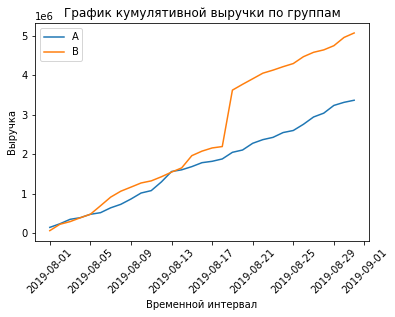

In [36]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.xticks(rotation=45 )

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Временной интервал')
plt.ylabel('Выручка')
plt.legend(); 

###   Вывод по шагу 3.1 
Выручка почти равномерно увеличивается в течение всего теста. 
Однако график выручки В резко вырос в одной точке. 

Т.к. выручка = конверсия * средний чек, поэтому если выручка выросла, то мог увеличится средний чек (возможно там были выбросы. Аномально большая сумма покупки), а могло увеличится количество заказов (т.е. конверсия).

В дальнейшем увеличение равномерно у обоих групп. Группа В после всплеска сохраняет свое первенство.

### 3.2 График кумулятивного среднего чека по группам

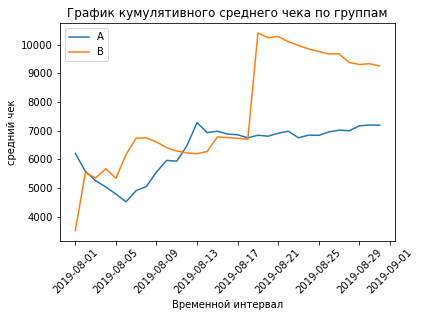

In [37]:
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Временной интервал')
plt.ylabel('средний чек')
plt.legend();

### Вывод по шагу 3.2

В группе В в тот же период времени (скачок кумулятивной выручки, п. 3.1) виден скачок среднего чека. Возможно это выброс. Далее в группе В средний чек уменьшается, а в группа А растет.

### 3.3 График относительного изменения кумулятивного среднего чека группы B к группе A. 

In [38]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a\
.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])



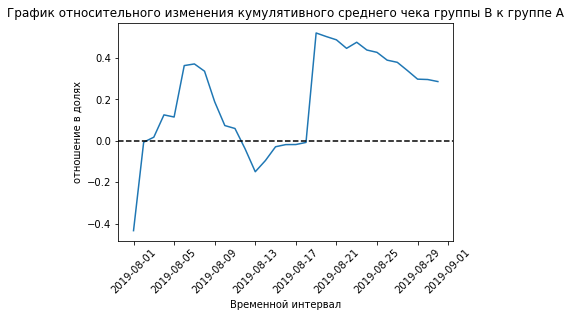

In [39]:
# cтроим отношение средних чеков
plt.plot(merged_cumulative_revenue['date'],\
         (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])\
         /(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Временной интервал')
plt.ylabel('отношение в долях');

### Вывод по шагу 3.3 
В нескольких точках график различия между сегментами резко «скачет». Это говорит о возможных крупных заказах или выбросах.

### 3.4 График кумулятивного среднего количества заказов на посетителя по группам. 

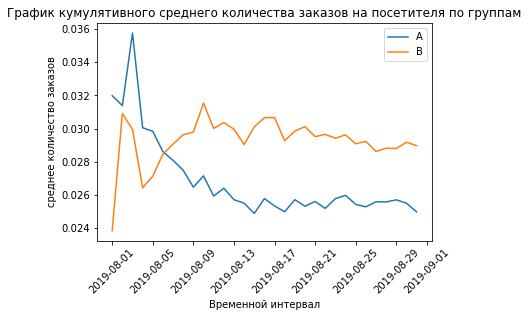

In [40]:
# считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Временной интервал')
plt.ylabel('среднее количество заказов')

plt.xticks(rotation=45);

### Вывод по шагу 3.4 
После конкретной даты графики изменились и в целом группа В имеет гораздо более высокий уровень кумулятивного среднего количества заказов на посетителя по группам, чем группа А. По динамике присутстуют колебания у обеих групп. Во второй половине теста обе группы отмечают значительную стабилизацию.

### 3.5  График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

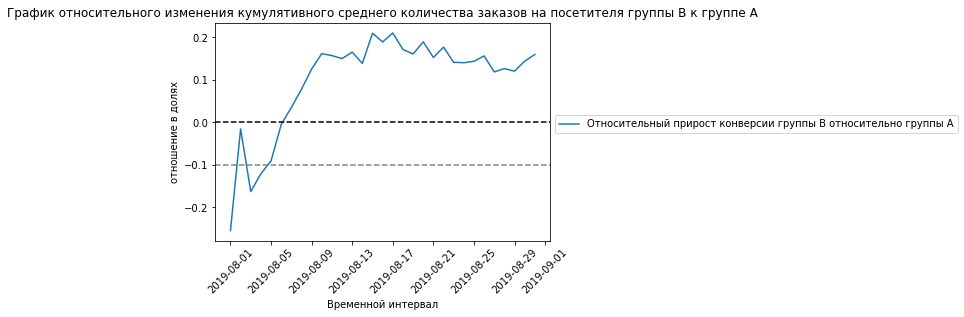

In [41]:
merged_сumulative_сonversions = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']],\
                                left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.plot(merged_сumulative_сonversions ['date'], merged_сumulative_сonversions ['conversion_b']\
         /merged_сumulative_сonversions ['conversion_a']-1, \
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend(bbox_to_anchor=(1, 0.6))

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Временной интервал')
plt.ylabel('отношение в долях');


### Вывод по шагу 3.5

В начале наблюдений группа В проигрывала группе А, но довольно резко ушла в отрыв. Потом произошел спад, но далее группа В опять резко улучшила свои показатели и далее всегда была луше, чем А. 

###  3.6 Точечный график стоимости заказов по пользователям. 

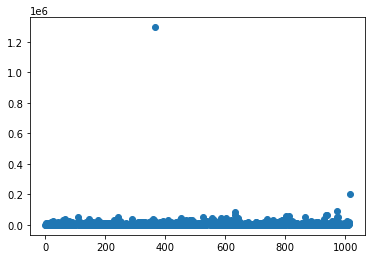

In [42]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) ;

построим этот график еще раз, ограничив ось у </div>

(0.0, 150000.0)

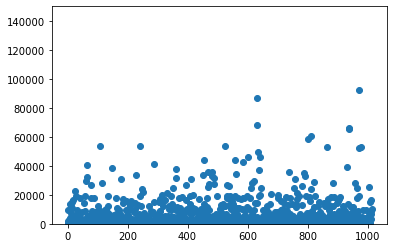

In [43]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim([0,150000])

### Вывод по 3.6 

Имеет место 2 выброса, причем один из них очень сильный. Он будет ильно влиять на данные.

### 3.7 Посчитем 90, 95-й и 99-й перцентили стоимости заказов на пользователя. 
Определим границу для определения аномальных пользователей.

In [44]:
print(np.percentile(orders['revenue'], [90,95, 99])) 

[17990. 26785. 53904.]


###  Вывод по шагу 3.7

Не более 5% заказов дороже 28000 у.е. и не более 1% дороже 58233.2 у.е. Будем считать последних аномальными пользователями. 
Установим верхнюю границу по заказам на уровне 30000 у.е.

### 3.8 Точечный график количества заказов по пользователям. 

In [45]:
orders_by_users = (
    orders.groupby('user_id', as_index=False)
    .agg({'order_id': 'nunique'})
)


orders_by_users.columns = ['user_id', 'orders']

print(orders_by_users.sort_values(by='orders', ascending=False).head(10)) 

        user_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


Есть несколько пользователей, которые сделали 11, 9 и 8 заказов. Это значительно больше, чем обычно

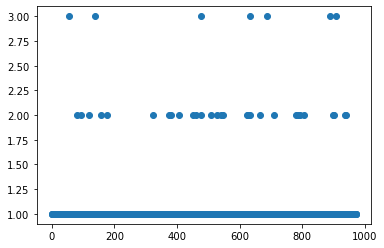

In [46]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.scatter(x_values, orders_by_users['orders']); 

###  Вывод по шагу 3.8

Больше всего пользователей сделало 1 заказ, потом идет группа с 2мя заказами. Пользователей, сделавших более 7 заказов можно считать аномалиями.

### 3.9 Посчитем 90, 95-й и 99-й перцентили количества заказов на пользователя. 
Определим границу для определения аномальных пользователей.

In [47]:
print(np.percentile(orders_by_users['orders'], [90, 95, 99])) 

[1. 1. 2.]


###  Вывод по шагу 3.8

Только менее 1 % пользователей сделало более 4х  заказов. Можем считатьэто верхней границей для выбросов.

### 3.10 Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

In [48]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'order_id', 'user_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'order_id', 'user_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'order_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

In [49]:
data.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Мы получили сводную таблицу, со следующими столбцами:

|столбец|описание|
|--:|:--|
|date |дата|
|orders_per_date_a|количество заказов в выбранную дату в группе |
|revenue_per_date_a|суммарная выручка в выбранную дату в группе |
|orders_per_date_b|количество заказов в выбранную дату в группе|
|revenue_per_date_b	| суммарная выручка в выбранную дату в группе|
|orders_cummulative_a|суммарное число заказов до выбранной даты включительно в группе|
|revenue_cummulative_a|суммарная выручка до выбранной даты включительно в группе |
|orders_cummulative_b |суммарное количество заказов до выбранной даты включительно в группе B|
|revenue_cummulative_b|суммарная выручка до выбранной даты включительно в группе B|
|visitors_per_date_a | количество пользователей в выбранную дату в группе A|
|visitors_per_date_b |количество пользователей в выбранную дату в группе B|
|visitors_cummulative_a | количество пользователей до выбранной даты включительно в группе A|
|visitors_cummulative_b|количество пользователей до выбранной даты включительно в группе B|

Создадим переменные orders_by_users_a и orders_by_users_b  со столбцами `user_id`, `orders`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [50]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('user_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b  = (
    orders[orders['group'] == 'B']
    .groupby('user_id', as_index=False)
    .agg({'order_id': pd.Series.nunique})
)
orders_by_users_b .columns = ['user_id', 'orders'] 

Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [51]:
sample_a = pd.concat([orders_by_users_a ['orders'],\
                     pd.Series(0, index=np.arange(data['visitors_per_date_a']\
                                                  .sum() - len(orders_by_users_a ['orders'])), name='orders')],axis=0)

sample_b = pd.concat([orders_by_users_b ['orders'],\
                     pd.Series(0, index=np.arange(data['visitors_per_date_b'].\
                                                  sum() - len(orders_by_users_b ['orders'])), name='orders')],axis=0)

Посчитаем p-value и  относительный прирост среднего числа заказов группы B

In [52]:

print("p-value равен  {0:.3f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print("относительный прирост среднего числа заказов группы B  соответствует {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))


p-value равен  0.006
относительный прирост среднего числа заказов группы B  соответствует 0.160


### Вывод по шагу 3.10

По «сырым» данным различия в среднем числе заказов групп A и B есть. 
Первое число — p-value = 0.008 меньше  0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, мы отвергаем. Относительный выигрыш группы B равен 13,8 % — второе число в выводе.

### 3.11 Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Нулевая гипотеза: различий в среднем чеке между группами нет. 
Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [53]:
print('p-value равен {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('отношение среднего чека  группы B  к чеку группы А равен  {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value равен 0.415
отношение среднего чека  группы B  к чеку группы А равен  0.287


### Вывод по шагу 3.11
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A. Поскольку относительное различие среднего чека между сегментами составляет ~28%, наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно были получены случайно.

###  3. 12 Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Сформулируем гипотезы. Нулевая: различий в среднем количестве заказов между группами нет. Альтернативная: различия в среднем между группами есть.

Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 30 000 у.е. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 3 — `users_with_many_orders` и пользователей, совершивших заказы дороже 30 000 — `users_with_expensive_orders`. Объединим их в таблице `abnormal_users`. 
Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [54]:
abnormal_count_orders = 3
abnormal_count_revenue = 30000



users_with_many_orders  = pd.concat(
    [
       orders_by_users_a[orders_by_users_a['orders'] > abnormal_count_orders]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > abnormal_count_orders]['user_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > abnormal_count_revenue]['user_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormal_users.head(5))
print(abnormal_users.shape[0])

1099    148427295
928     204675465
684     358944393
648     382846391
751     689129267
Name: user_id, dtype: int64
42


у нас 57 аномальных пользователей. Посмотрим, как они повлияли на результат.

In [55]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [56]:
print('p-value равен {0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered )[1]))
print('относительный прирост среднего числа заказов группы B  соответствует {0:.3f}'.format(sample_b_filtered .mean()/sample_a_filtered.mean()-1)) 

p-value равен 0.007
относительный прирост среднего числа заказов группы B  соответствует 0.161


### Вывод по шагу 3.12
P-value меньше 0.05. Значит, стоит отвергнуть нулевую гипотезу и считать, что в среднем чеке есть различия. Средний чек группы B значительно выше среднего чека группы A. 

### 3.13 Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [57]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['user_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['user_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['user_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['user_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.421
-0.031


### Вывод по шагу 3.13
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 
В случае сырых данных результат был такой же. Не отвергать нулевую гипотезу. Но на отчищенных данных P-value больше. 

0.479 и 0.365
А отношение среднего чека  группы B  к чеку группы А изменилось относительно сырых данных  -0.020 вместо  0.259 на всех данных.


# Общий вывод: 

## 1. Приоритет гипотез

При оценке 9 предложенных гипотез были посчитаны 2 фреймворка ICE  и RICE. 
Если не брать во внимание парамер `reach` (Количество пользователей, которых затронет изменение) то наиболее приоритетной следует считать гипотезу "Запустить акцию, дающую скидку на товар в день рождения"

Если считать параметр `reach` важным, то согласно фреймворку  RICE главной следует считать гипотезу:
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"

## 2. А/Б тест

Решение: Остановить тест, зафиксировать победу одной из групп.

Имеющиеся факты:

- Нет статистически значимого различия по среднему количеству заказов между группами по «сырым» данным, но она появляется, если мы берем данные  после фильтрации аномалий;
 - Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
 - График различия конверсии между группами сообщает, что результаты группы B лучше группы A и эта тенденция сохраняется
 - График различия среднего чека говорит о том, что результаты группы B значительно лучше, чем  в группе А, но начали немного снижаться.

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Есть все основания считать, что группа В успешнее по количеству заказов, но не успешнее по среднему чеку. 